## OPENBIB - Working with BigQuery

In [31]:
from google.cloud import bigquery
from matplotlib.ticker import StrMethodFormatter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
client = bigquery.Client(project='subugoe-collaborative')

In [5]:
openbib_inst = client.query(f"""
                            SELECT COUNT(DISTINCT(oal.doi)) AS n, oal.ror AS oal_ror, kb_inst.ror AS kb_ror, sector
                            FROM `subugoe-collaborative.openbib.kb_a_addr_inst` AS inst, UNNEST(kb_sector_id) AS sector
                            JOIN (
                              SELECT o.doi, inst.ror
                              FROM `subugoe-collaborative.openalex.works` AS o, UNNEST(authorships) AS aut, UNNEST(aut.institutions) As inst
                              WHERE inst.country_code = 'DE' AND publication_year BETWEEN 2014 AND 2024
                            ) AS oal
                              ON LOWER(inst.doi) = LOWER(oal.doi)
                            JOIN `subugoe-collaborative.openbib.kb_inst` AS kb_inst
                              ON inst.kb_inst_id = kb_inst.kb_inst_id
                            GROUP BY oal_ror, kb_ror, sector
                            """).to_dataframe()

In [67]:
oal_ror = openbib_inst.groupby(['oal_ror', 'sector'])['n'].sum().reset_index()
kb_ror = openbib_inst.groupby(['kb_ror', 'sector'])['n'].sum().reset_index()

openbib_inst_plot = oal_ror.merge(kb_ror, left_on=['oal_ror', 'sector'], right_on=['kb_ror', 'sector'], how='left', suffixes=('_oal', '_kb'))
openbib_inst_plot = openbib_inst_plot[openbib_inst_plot.sector.isin(['uni', 'fh', 'hgf', 'fhg', 'mpg', 'wgl'])]

openbib_inst_plot.replace(dict(
    uni='University',
    fh='Fachhochschule',
    mpg='Max Planck Society',
    hgf='Helmholtz Association',
    fhg='Fraunhofer Society',
    wgl='Leibniz Association'
), inplace=True)

openbib_inst_plot.sort_values(by=['sector'], ascending=False, inplace=True)

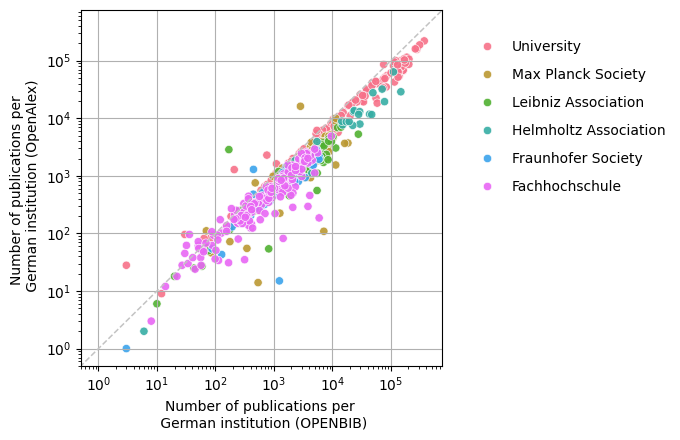

In [68]:
fig, ax = plt.subplots(figsize=(7, 4.5))

x = [x for x in range(-1000, 1000000, 10000)]
y = x

plt.grid(True)

sns.scatterplot(data=openbib_inst_plot,
                x='n_kb',
                y='n_oal',
                hue='sector',
                alpha=0.9,
                palette='husl')

sns.lineplot(x=x, 
             y=y, 
             color='#c3c3c3', 
             linestyle='dashed', 
             linewidth=1.1,
             alpha=1)

ax.set_xlim(2**-1, 15**5)
ax.set_ylim(2**-1, 15**5)

plt.xscale('log')
plt.yscale('log')

ax.set(xlabel='Number of publications per \n German institution (OPENBIB)', 
       ylabel='Number of publications per \n German institution (OpenAlex)')

ax.legend(bbox_to_anchor=(1.05, 0.95),
          frameon=False,
          labelspacing=1.0)

plt.tight_layout()
plt.show()
fig.savefig('kb_institution_disambiguation.png', format='png', bbox_inches='tight', dpi=500)

In [25]:
doc_sectors_df = client.query(f"""
                              SELECT COUNT(DISTINCT(dt.doi)) AS n, kb_inst_id AS institution, sector, is_research
                              FROM subugoe-collaborative.openbib.kb_a_addr_inst AS kb_a, UNNEST(kb_sector_id) AS sector
                              JOIN subugoe-collaborative.openbib.document_types AS dt
                                  ON LOWER(dt.doi) = LOWER(kb_a.doi)
                              GROUP BY sector, institution, is_research
                              """
                              ).to_dataframe()

In [57]:
doc_sectors_df_uni_is_research = doc_sectors_df[(doc_sectors_df.sector=='uni') & (doc_sectors_df.is_research==True)].groupby(['institution'])['n'].sum().reset_index()
doc_sectors_df_uni_all = doc_sectors_df[doc_sectors_df.sector=='uni'].groupby(['institution'])['n'].sum().reset_index()
doc_sectors_df_uni = doc_sectors_df_uni_all.merge(doc_sectors_df_uni_is_research, on='institution', suffixes=('_all', '_is_research'))

In [58]:
doc_sectors_df_is_research = doc_sectors_df[doc_sectors_df.is_research==True].groupby(['institution', 'sector'])['n'].sum().reset_index()
doc_sectors_df_all = doc_sectors_df.groupby(['institution', 'sector'])['n'].sum().reset_index()
doc_sectors_df_plot = doc_sectors_df_all.merge(doc_sectors_df_is_research, on=['institution', 'sector'], suffixes=('_all', '_is_research'))

In [59]:
doc_sectors_df_plot = doc_sectors_df_plot[doc_sectors_df_plot.sector.isin(['uni', 'wgl', 'hgf', 'fh', 'mpg', 'fhg'])]
doc_sectors_df_plot = doc_sectors_df_plot.replace('uni', 'University')
doc_sectors_df_plot = doc_sectors_df_plot.replace('wgl', 'Leibniz Association')
doc_sectors_df_plot = doc_sectors_df_plot.replace('hgf', 'Helmholtz Association')
doc_sectors_df_plot = doc_sectors_df_plot.replace('fh', 'Fachhochschule')
doc_sectors_df_plot = doc_sectors_df_plot.replace('mpg', 'Max Planck Society')
doc_sectors_df_plot = doc_sectors_df_plot.replace('fhg', 'Fraunhofer Society')

doc_sectors_df_plot.sort_values(by=['sector'], ascending=False, inplace=True)

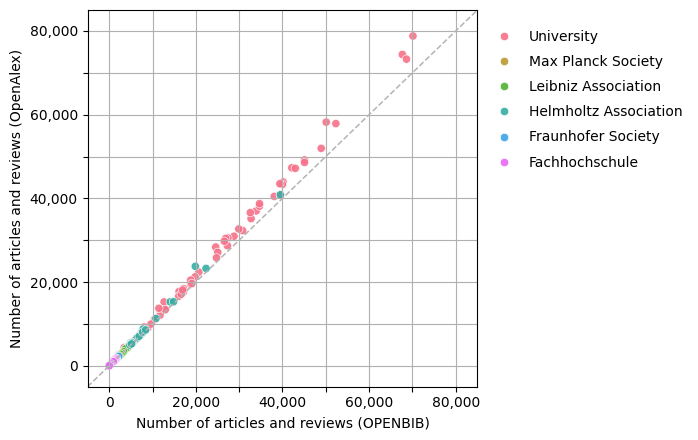

In [66]:
fig, ax = plt.subplots(figsize=(5, 4.5))

plt.grid(True)

x = [x for x in range(-5000, 90000, 5000)]
y = x    
    
sns.scatterplot(data=doc_sectors_df_plot, 
                x='n_is_research', 
                y='n_all',
                alpha=0.9,
                palette='husl',
                hue='sector')

sns.lineplot(x=x, 
             y=y, 
             color='#b3b3b3a0', 
             linestyle='dashed', 
             linewidth=1.1,
             alpha=1)

ax.set_xlim(-5000, 85000)
ax.set_ylim(-5000, 85000)

ax.get_legend().remove()

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.setp(ax.get_xticklabels()[::2], visible=False)
plt.setp(ax.get_yticklabels()[::2], visible=False)

ax.set(xlabel='Number of articles and reviews (OPENBIB)', ylabel='Number of articles and reviews (OpenAlex)')

lgd = fig.legend(frameon=False, 
                 bbox_to_anchor=(1.4, 0.95),
                 labelspacing=0.8)

plt.tight_layout()
plt.show()
fig.savefig('document_types_sectors.png', format='png', bbox_inches='tight', dpi=500)